In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

In [4]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 15

## Convert the data into TensorFlow `Dataset` objects

In [5]:
# Put aside a few samples to create our validation set
# val samples should be 
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Define the mixup technique function

In [1]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels, images_one, labels_one, images_two, labels_two)

## Visualize the new augmented dataset

(64, 28, 28, 1) (64, 28, 28, 1)
(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


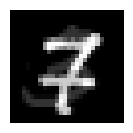

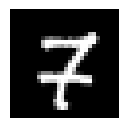

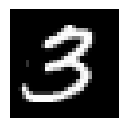

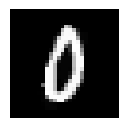

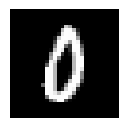

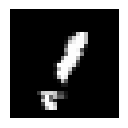

In [14]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.4), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels, images_one, labels_one, images_two, labels_two = next(iter(train_ds_mu))

ds_one, ds_two = next(iter(train_ds))

print(ds_one[0].shape, ds_two[0].shape)
print(train_ds_mu.element_spec)

# plot all ds_one and ds_two images
# for i, (image, label) in enumerate(zip(ds_one[0][:6], ds_one[1][:6])):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image.numpy().squeeze(), cmap='gray')
#     plt.axis("off")
    # plt.show()

plt.figure(figsize=(5, 5))
for i, (image, label) in enumerate(zip(sample_images[:2], sample_labels[:2])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.axis("off")
    plt.show()

    # also print the original images
    ax = plt.subplot(3, 3, i + 4)
    plt.imshow(images_one[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    plt.show()

    ax = plt.subplot(3, 3, i + 4)
    plt.imshow(images_two[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    plt.show()

# plt.show()

## Model Building

In [14]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
    layers.Conv2D(32, (5, 5), activation="relu"),
    layers.Flatten(),
    layers.Dense(10, activation="softmax"),
])

    # layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    # layers.MaxPooling2D((2, 2)),
    # layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(10)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.fit(
    train_ds_one,
    epochs=EPOCHS,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/10
454/454 [==============================] - 7s 14ms/step - loss: 0.1778 - categorical_accuracy: 0.9498 - val_loss: 0.0888 - val_categorical_accuracy: 0.9755
Epoch 2/10
454/454 [==============================] - 6s 14ms/step - loss: 0.0554 - categorical_accuracy: 0.9832 - val_loss: 0.0650 - val_categorical_accuracy: 0.9810
Epoch 3/10
454/454 [==============================] - 6s 13ms/step - loss: 0.0389 - categorical_accuracy: 0.9879 - val_loss: 0.0562 - val_categorical_accuracy: 0.9850
Epoch 4/10
454/454 [==============================] - 6s 13ms/step - loss: 0.0293 - categorical_accuracy: 0.9908 - val_loss: 0.0656 - val_categorical_accuracy: 0.9840
Epoch 5/10
454/454 [==============================] - 6s 14ms/step - loss: 0.0226 - categorical_accuracy: 0.9930 - val_loss: 0.0530 - val_categorical_accuracy: 0.9835
Epoch 6/10
454/454 [==============================] - 6s 14ms/step - loss: 0.0183 - categorical_accuracy: 0.9944 - val_loss: 0.0543 - val_categorical_accuracy: 0.986

In [10]:
# save model
model.save('assets/models_mu/mnist_model.h5')

#### Define Function to combine adv dataset with train, val and test datasets

In [6]:
transforms = Compose([
        RandomBrightness(limit=0.1),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        HorizontalFlip(p=0.5),
    ])

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [70]:
def merge_adv(X_adv_train, y_adv_train, adv_mixup=False, allow_aug = False):
    val_samples = 2000
    x_val, y_val = x_train[:val_samples], y_train[:val_samples]
    new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

    if(adv_mixup):
        # apply transforms to new_x_train
        if(allow_aug):
            X_adv_train = np.array([aug_fn(image, 28) for image in X_adv_train])

        # create train_ds_one_adv and train_ds_two_adv
        train_ds_one_adv = (
            tf.data.Dataset.from_tensor_slices((X_adv_train, y_adv_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )

        train_ds_two_adv = (
            tf.data.Dataset.from_tensor_slices((X_adv_train, y_adv_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )

        # Because we will be mixing up the images and their corresponding labels, we will be
        # combining two shuffled datasets from the same training data.
        train_ds_adv = tf.data.Dataset.zip((train_ds_one_adv, train_ds_two_adv))

        val_ds_adv = tf.data.Dataset.from_tensor_slices(
            (x_val, y_val)).batch(BATCH_SIZE)

        test_ds_adv = tf.data.Dataset.from_tensor_slices(
            (x_test, y_test)).batch(BATCH_SIZE)

        train_ds_mu_adv = train_ds_adv.map(
            lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
        )

        # concat X_adv_train, y_adv_train to train_ds_mu
        train_ds = (
            tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )

        train_ds_adv = train_ds_mu_adv.concatenate(train_ds)

        return train_ds_adv, val_ds_adv, test_ds_adv

    else:

        # apply transforms to new_x_train
        if(allow_aug):
            new_x_train = np.array([aug_fn(image, 28) for image in new_x_train])

         # create train_ds_one and train_ds_two
        train_ds_one = (
            tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )

        train_ds_two = (
            tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )

        # Because we will be mixing up the images and their corresponding labels, we will be
        # combining two shuffled datasets from the same training data.
        train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

        val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

        test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
        
        train_ds_mu = train_ds.map(
            lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
        )

        # concat X_adv_train, y_adv_train to train_ds_mu
        train_ds_adv = (
            tf.data.Dataset.from_tensor_slices((X_adv_train, y_adv_train))
            .shuffle(BATCH_SIZE * 100)
            .batch(BATCH_SIZE)
        )
        
        train_ds_adv = train_ds_adv.concatenate(train_ds_mu)

        return train_ds_adv, val_ds, test_ds


Training on: z3


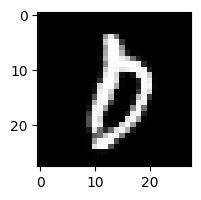

Epoch 1/15
1087/1087 - 11s - loss: 1.8601 - categorical_accuracy: 0.3320 - val_loss: 1.4989 - val_categorical_accuracy: 0.4015 - 11s/epoch - 10ms/step
Epoch 2/15
1087/1087 - 11s - loss: 1.4928 - categorical_accuracy: 0.3685 - val_loss: 1.2944 - val_categorical_accuracy: 0.4025 - 11s/epoch - 10ms/step
Epoch 3/15
1087/1087 - 11s - loss: 1.3701 - categorical_accuracy: 0.3803 - val_loss: 1.2101 - val_categorical_accuracy: 0.4285 - 11s/epoch - 10ms/step
Epoch 4/15
1087/1087 - 10s - loss: 0.9935 - categorical_accuracy: 0.6129 - val_loss: 0.6439 - val_categorical_accuracy: 0.6960 - 10s/epoch - 9ms/step
Epoch 5/15
1087/1087 - 10s - loss: 0.7599 - categorical_accuracy: 0.6541 - val_loss: 0.5379 - val_categorical_accuracy: 0.7750 - 10s/epoch - 9ms/step
Epoch 6/15
1087/1087 - 10s - loss: 0.5571 - categorical_accuracy: 0.8437 - val_loss: 0.2140 - val_categorical_accuracy: 0.9860 - 10s/epoch - 9ms/step
Epoch 7/15
1087/1087 - 10s - loss: 0.3569 - categorical_accuracy: 0.9095 - val_loss: 0.1100 - val

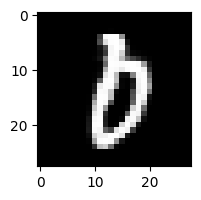

Epoch 1/15
1074/1074 - 11s - loss: 2.0668 - categorical_accuracy: 0.2425 - val_loss: 1.6281 - val_categorical_accuracy: 0.4010 - 11s/epoch - 10ms/step
Epoch 2/15
1074/1074 - 10s - loss: 1.4134 - categorical_accuracy: 0.4464 - val_loss: 1.1106 - val_categorical_accuracy: 0.5135 - 10s/epoch - 9ms/step
Epoch 3/15
1074/1074 - 10s - loss: 1.1687 - categorical_accuracy: 0.4852 - val_loss: 0.9117 - val_categorical_accuracy: 0.6170 - 10s/epoch - 10ms/step
Epoch 4/15
1074/1074 - 10s - loss: 0.9030 - categorical_accuracy: 0.6118 - val_loss: 0.5987 - val_categorical_accuracy: 0.7125 - 10s/epoch - 9ms/step
Epoch 5/15
1074/1074 - 10s - loss: 0.7110 - categorical_accuracy: 0.6863 - val_loss: 0.4537 - val_categorical_accuracy: 0.7975 - 10s/epoch - 9ms/step
Epoch 6/15
1074/1074 - 10s - loss: 0.5758 - categorical_accuracy: 0.7477 - val_loss: 0.3770 - val_categorical_accuracy: 0.7970 - 10s/epoch - 9ms/step
Epoch 7/15
1074/1074 - 11s - loss: 0.4736 - categorical_accuracy: 0.8261 - val_loss: 0.2412 - val_

In [71]:
# iterate through each mnist zico defense by attack folder and train on the images inside them
folder_path = 'assets/'
adv_models = {}

for adv_path in os.listdir(folder_path):
    # if attack folder contains string and is a folder
    if 'mnist_zico_defense_by_attack' in adv_path and os.path.isdir(os.path.join(folder_path, adv_path)):
        id = adv_path.split('_')[-1]
        if(id == 'z3' or id == 'z6'):
            print(f'Training on: {id}')
            # load mnist_adv dataset
            adv_files = []
            X = []
            y = []

            # for loop to load all the images
            for source in range(10):
                for target in range(10):
                    if(source != target):
                        file = np.load(os.path.join(folder_path, adv_path) + '/from' + str(source) + 'to' + str(target) + '.npz')
                        adv_files.append(file)
                        y.extend(np.full(len(file['adv_imgs']), source).tolist())

            keys = adv_files[0].files

            for file in adv_files:
                with file as data:
                    X.extend(data[keys[0]])

            X = np.array(X).astype(np.float32)
            y = np.array(y)
            y_one_hot = np.take(np.eye(10), y, axis=0).astype(np.float32)

            plt.figure(figsize=(2, 2))
            plt.imshow(X[0], cmap='gray')
            plt.show()

            # merge X_train_adv_1 and y_train_adv_1 to create a new dataset
            train_ds_mu_adv, val_ds_adv, test_ds_adv = merge_adv(X, y_one_hot, adv_mixup=True, allow_aug=True)

            model_adv = tf.keras.models.Sequential([
                layers.Conv2D(16, 5, activation="relu", input_shape=(28, 28, 1)),
                layers.Conv2D(32, 5, activation="relu"),
                layers.Flatten(),
                layers.Dense(128, activation="softmax"),
                layers.Dense(10, activation="softmax"),
            ])

            model_adv.compile(
                optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()],
            )

            model_adv.fit(
                train_ds_mu_adv,
                epochs=EPOCHS,
                validation_data=val_ds_adv,
                shuffle=True,
                verbose=2
            )

            adv_models[id] = model_adv

In [72]:
for adv_model in adv_models:
    # save model_adv
    adv_models[adv_model].save(f'assets/models_mu/mnist_adv_model_{adv_model}.h5')